## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
##Importing required stats/DL/ML packages. E.g. Keras, scikit-learn, etc.

%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import scipy
import seaborn as sns
import sklearn.model_selection as skl
import tensorflow as tf

from glob import glob
from random import sample
from itertools import chain
from random import sample 
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score, auc, precision_score,precision_recall_curve, average_precision_score

Using TensorFlow backend.


## Performing early processing of metadata for easier model training:

In [2]:
## Loading the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

In [3]:
## Creating extra columns in table with binary indicators of certain diseases 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
95080  00024797_000.png     No Finding            0       24797           33   
85154  00020994_001.png     No Finding            1       20994           44   
7198   00001901_000.png     No Finding            0        1901           58   

      Patient Gender View Position  OriginalImage[Width  Height]  \
95080              M            PA                 3056     2544   
85154              M            PA                 2992     2991   
7198               F            PA                 2992     2991   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
95080                        0.139  ...          0         0       0   
85154                        0.143  ...          0         0       0   
7198                         0.143  ...          0         0       0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
95080             0     0           1       0                   0          0   
85154             0     0           1       0                   0          0   
7198              0     0           1       0                   0          0   

       Pneumothorax  
95080             0  
85154             0  
7198              0  

[3 rows x 27 columns]

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['image_path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index   Finding Labels  Follow-up #  Patient ID  \
73091  00018006_008.png       No Finding            8       18006   
9233   00002411_006.png       No Finding            6        2411   
21184  00005663_007.png  Fibrosis|Nodule            7        5663   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
73091           60              M            AP                 2500     2048   
9233            35              M            AP                 2500     2048   
21184           61              M            PA                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia  Infiltration  Mass  \
73091                        0.168  ...         0       0             0     0   
9233                         0.168  ...         0       0             0     0   
21184                        0.168  ...         1       0             0     0   

       No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
73091           1       0                   0          0             0   
9233            1       0                   0          0             0   
21184           0       1                   0          0             0   

                                     image_path  
73091  /data/images_008/images/00018006_008.png  
9233   /data/images_002/images/00002411_006.png  
21184  /data/images_003/images/00005663_007.png  

[3 rows x 28 columns]

In [5]:
# Changing the column names for easy access and manuplation

all_xray_df.columns = all_xray_df.columns.str.replace('\.*\s+', '_').str.lower()
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: '1' if row.pneumonia==1.0 else '0', axis=1)
all_xray_df.sample(3)

image_index finding_labels  follow-up_#  patient_id  patient_age  \
42631  00010980_003.png     No Finding            3       10980           51   
91608  00022837_039.png     No Finding           39       22837           66   
35835  00009443_001.png   Infiltration            1        9443           27   

      patient_gender view_position  originalimage[width  height]  \
42631              M            PA                 2992     2991   
91608              M            PA                 3056     2544   
35835              F            PA                 2774     2881   

       originalimagepixelspacing[x  ...  hernia  infiltration  mass  \
42631                        0.143  ...       0             0     0   
91608                        0.139  ...       0             0     0   
35835                        0.143  ...       0             1     0   

       no_finding  nodule  pleural_thickening  pneumonia  pneumothorax  \
42631           1       0                   0          0             0   
91608           1       0                   0          0             0   
35835           0       0                   0          0             0   

                                     image_path  pneumonia_class  
42631  /data/images_005/images/00010980_003.png                0  
91608  /data/images_010/images/00022837_039.png                0  
35835  /data/images_005/images/00009443_001.png                0  

[3 rows x 29 columns]

## Creating training and testing data seta:

In [6]:
## Train and Validated Split

train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df.pneumonia)

In [7]:
# Checking counts of pneumonia and non pneumonia in validation dataset

valid_df.pneumonia_class.value_counts()

0    22138
1      286
Name: pneumonia_class, dtype: int64

In [8]:
train_df.pneumonia.sum()/len(train_df)

0.012765340706386016

In [9]:
valid_df.pneumonia.sum()/len(valid_df)

0.012754191937210132

In [10]:
p_inds = train_df[train_df.pneumonia==1].index.tolist()
np_inds = train_df[train_df.pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [11]:
train_df.pneumonia.sum()/len(train_df)

0.5

In [12]:
p_inds = valid_df[valid_df.pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [13]:
valid_df.pneumonia.sum()/len(valid_df)

0.2

In [14]:
## Function for Checking duplicate X-ray images in training and Validation dataset

def check_for_image_in_train_valid(train_df, valid_df):
    
    
    train_df_image_unique = set(train_df.image_index.values)
    valid_df_image_unique = set(valid_df.image_index.values)
    
    
    image_in_both_sets = list(train_df_image_unique.intersection(valid_df_image_unique))

    
    if (len(image_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate

In [15]:
check_for_image_in_train_valid(train_df, valid_df)

False

In [16]:
## Function for Checking duplicate patient in training and Validation dataset

def check_for_patient_in_train_valid(train_df, valid_df):
    
    
    train_df_patients_unique = set(train_df.patient_id.values)
    valid_df_patients_unique = set(valid_df.patient_id.values)
    
    
    patients_in_both_sets = list(train_df_patients_unique.intersection(valid_df_patients_unique))

    
    if (len(patients_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate

In [17]:
check_for_patient_in_train_valid(train_df, valid_df)

True

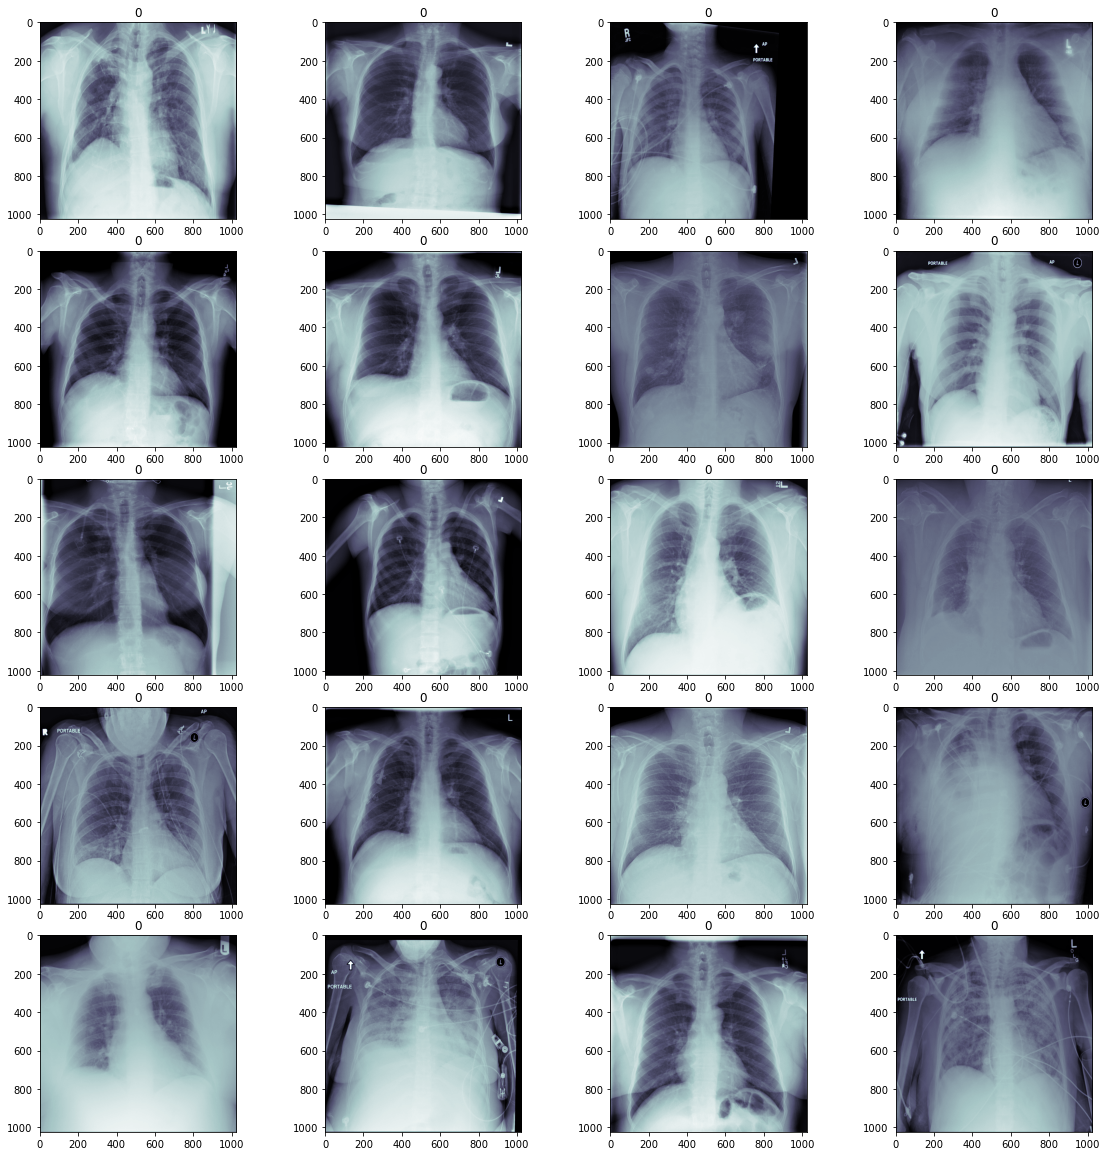

In [18]:
#First, let's look at what our plian images look like

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
plt.tight_layout()
imgs = all_xray_df.image_path.sample(20)
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='bone')
    ax.set_title(all_xray_df.iloc[ind].pneumonia)
    ind=ind+1

In [19]:
#X-ray Image Augmenetation for Training Dataset

def get_train_gen(train_df, image_dir, x_cols, y_cols, shuffle=True, batch_size=64, seed=1, target_w = 224, target_h = 224):
    print("getting train generator...") 
    # normalize images
    image_gen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.1, 
                                   width_shift_range=0.1,
                                   rotation_range=10,
                                   shear_range = 0.1,
                                   zoom_range=0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_gen = image_gen.flow_from_dataframe(
            dataframe=train_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode='raw',
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed,
            target_size=(target_w,target_h))
    
    return train_gen


In [20]:
###X-ray Image Augmenetation for Validation Dataset

def get_valid_gen(valid_df, image_dir, x_cols, y_cols, batch_size=64, seed=1, target_w = 224, target_h = 224):
    print("getting valid generators...")

    # get data sample
    batch = train_gen.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_gen = ImageDataGenerator(rescale=1./255,
                                   )
    
    # get test generator
    valid_gen = image_gen.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode='raw',
            batch_size=batch_size,
            shuffle=True,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_gen

In [21]:
train_gen = get_train_gen(train_df, None, 'image_path', 'pneumonia')
valid_gen= get_valid_gen(valid_df, None, 'image_path', 'pneumonia')

getting train generator...
Found 2290 validated image filenames.
getting valid generators...
Found 1430 validated image filenames.


In [22]:
t_x, t_y = next(train_gen)
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())

Train 0.0 1.0 0.49262813 0.24496286


In [23]:
valX, valY = valid_gen.next()

In [24]:
valY

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

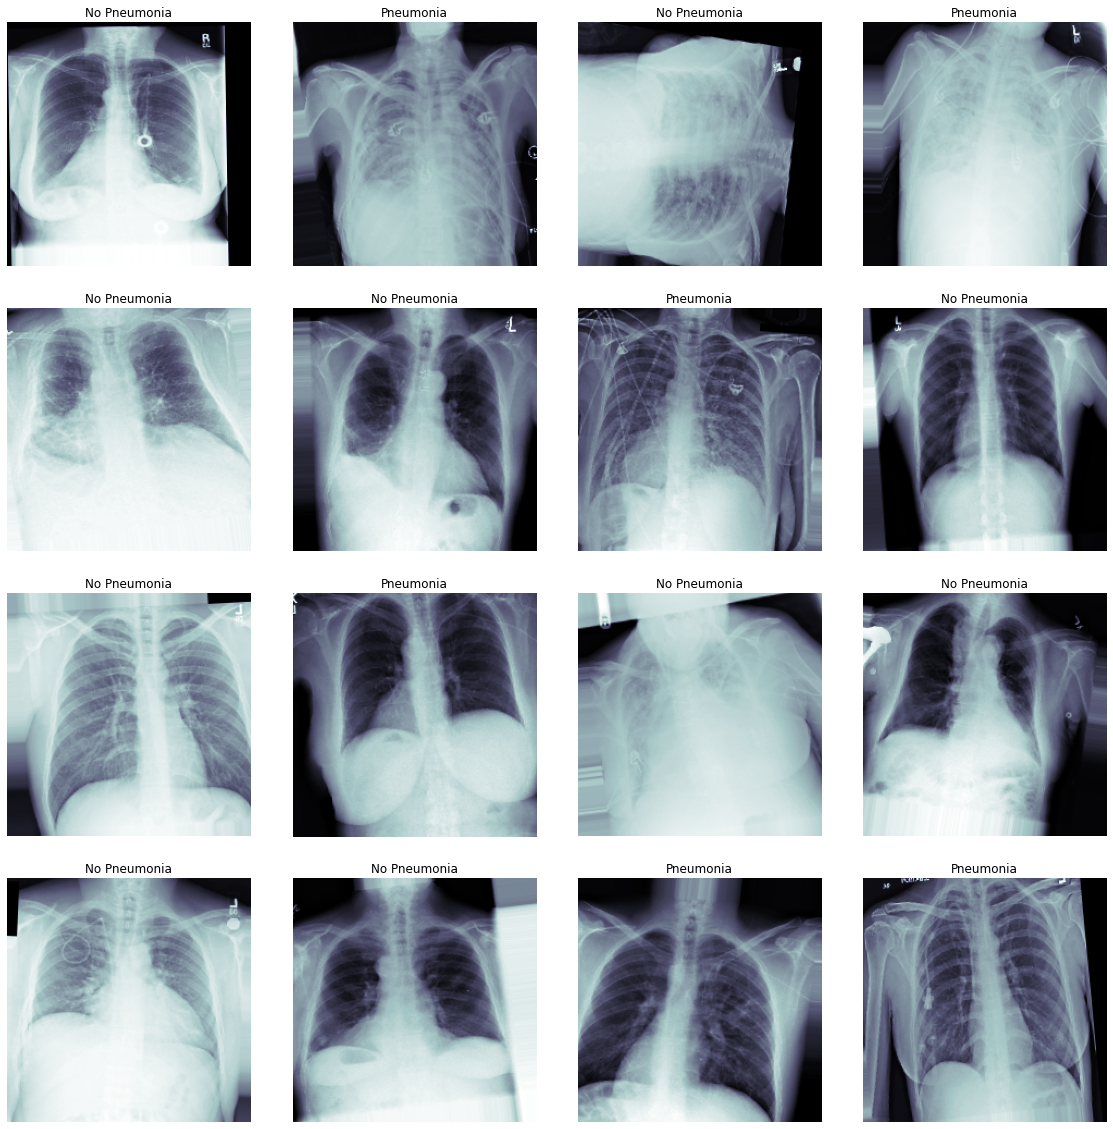

In [25]:
## X-ray images of Training Sets

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

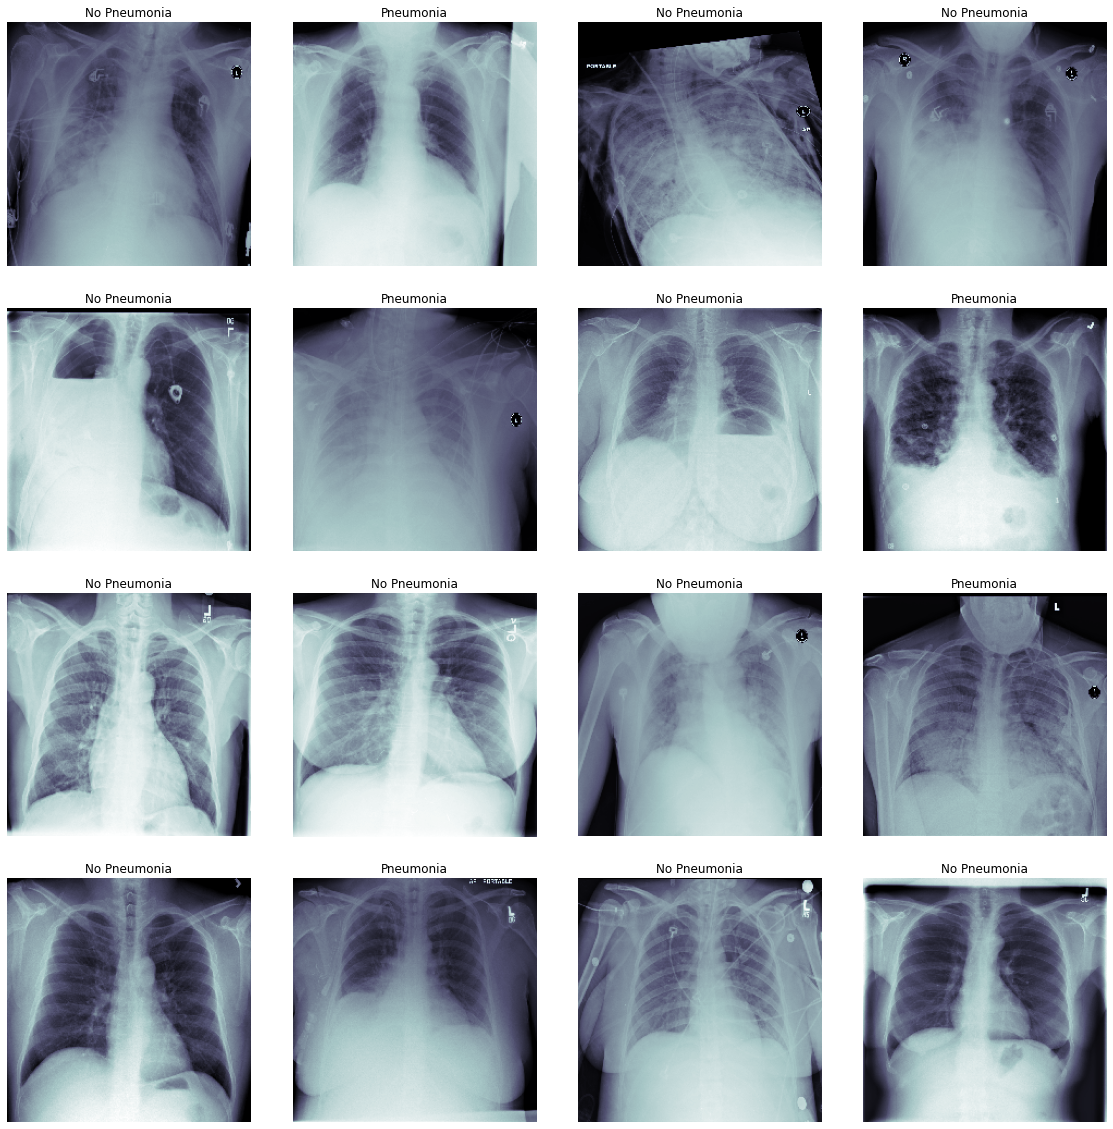

In [26]:
## X-ray images of Valdiation Sets

v_x, v_y = next(valid_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(v_x, v_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
        label = 1
    else:
        c_ax.set_title('No Pneumonia')
        label = 0
    
    
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [27]:
## Loading pretrained model VGG16

def load_pretrained_model(include_top, weights, lay_of_interest ):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=include_top, weights=weights)
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    
    return vgg_model


In [28]:
vgg_model = load_pretrained_model(True,'imagenet', 'block5_pool')

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [29]:
vgg_model.layers

In [30]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [31]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [32]:
##Creating New Model 

new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

## Layers added
new_model.add(Dropout(0.5))
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(256, activation='relu'))
## Layers
new_model.add(Dense(1, activation='sigmoid'))

In [33]:
optimizer = Adam(lr=1e-4) 
loss = 'binary_crossentropy' 
metrics = ['binary_accuracy']

In [34]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor= 'val_binary_accuracy', verbose=1, save_best_only=True, mode= 'max', save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', mode= 'min', patience=10)

callbacks_list = [checkpoint, early]

In [36]:
weight_path

'xray_class_my_model.best.hdf5'

In [37]:
history = new_model.fit_generator(train_gen, validation_data = (valX, valY),  epochs = 10, callbacks=callbacks_list)

Epoch 1/10
36/36 [==============================] - 67s 2s/step - loss: 0.7870 - binary_accuracy: 0.5205 - val_loss: 0.6656 - val_binary_accuracy: 0.6562

Epoch 00001: val_binary_accuracy improved from -inf to 0.65625, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.7214 - binary_accuracy: 0.5472 - val_loss: 0.6215 - val_binary_accuracy: 0.7812

Epoch 00002: val_binary_accuracy improved from 0.65625 to 0.78125, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.7146 - binary_accuracy: 0.5218 - val_loss: 0.6572 - val_binary_accuracy: 0.7188

Epoch 00003: val_binary_accuracy did not improve from 0.78125
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6999 - binary_accuracy: 0.5358 - val_loss: 0.7268 - val_binary_accuracy: 0.4375

Epoch 00004: val_binary_accuracy did not improve from 0.78125
Epoch 5/10
36/36 [===============

In [38]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

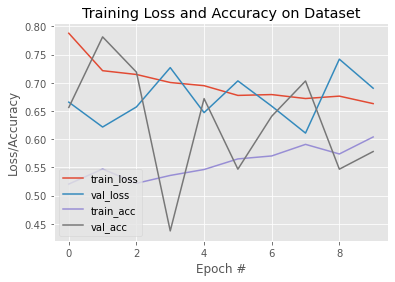

In [39]:
plot_history(history)

Predicted Value of New Model

In [40]:
new_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 11ms/step


New Model Key Metrics 

In [41]:
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


# function for Ket Metrics

def key_metrics(valY, pred_Y):

    acc = accuracy_score(valY, np.round(pred_Y))*100
    cm = confusion_matrix(valY, np.round(pred_Y), labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
   
   

    print('TRAIN METRIC ----------------------')
    print('Train acc: {}%'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))
    
    print('TEST METRICS ----------------------')
    print('Accuracy: {}%'.format(acc))
    
    print('True Negative: {}'.format(tn))
    print('True Positive: {}'.format(tp))
    print('False Negative: {}'.format(fn))
    print('False Positive: {}'.format(fp))
    print(' ')
    print('Sensitivity: {}'.format(sensitivity))
    print(' ')
    print('specificity: {}'.format(specificity))
    print(' ')
    print('Confusion Matrix: {}'.format(cm))
    print(' ')
     
    print('Threshold where Precision is 0.8--------------------')
    precision_value = 0.8
    idx = (np.abs(precision - precision_value)).argmin() 
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
    print(' ')
    
    print('Threshold where Recall is 0.8--------------------')
    recall_value = 0.8
    idx = (np.abs(recall - recall_value)).argmin() 
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

In [42]:
key_metrics(valY, pred_Y)

TRAIN METRIC ----------------------
Train acc: 60.39%
TEST METRICS ----------------------
Accuracy: 78.125%
True Negative: 47
True Positive: 3
False Negative: 10
False Positive: 4
 
Sensitivity: 0.23076923076923078
 
specificity: 0.9215686274509803
 
Confusion Matrix: [[47  4]
 [10  3]]
 
Threshold where Precision is 0.8--------------------
Precision is: 0.75
Recall is: 0.23076923076923078
Threshold is: 0.5085524
F1 Score is: 0.3529411764705882
 
Threshold where Recall is 0.8--------------------
Precision is: 0.1724137931034483
Recall is: 0.7692307692307693
Threshold is: 0.39039937
F1 Score is: 0.28169014084507044


New Model ROC curve

In [43]:
def plot_auc(valY, pred_Y):
    lw=2
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(valY, pred_Y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('pneumonia', auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

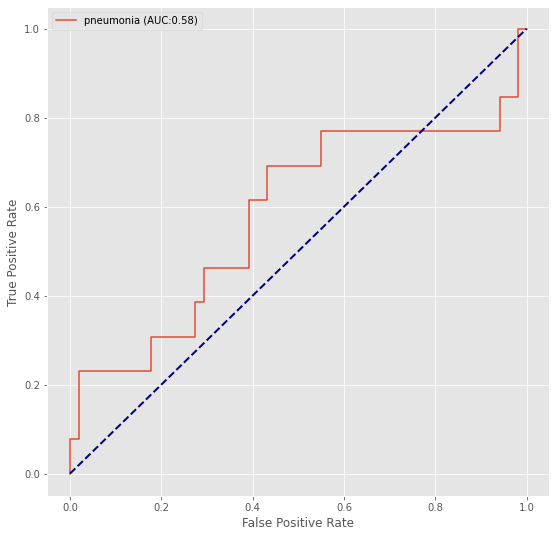

In [44]:
plot_auc(valY, pred_Y)

In [45]:
def plot_pr(valY, pred_Y):
    fig, c_ax = plt.subplots(1, 1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    c_ax.plot(precision, recall, label='%s (AP Score:%0.2f)' % ('pneumonia', average_precision_score(valY, pred_Y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

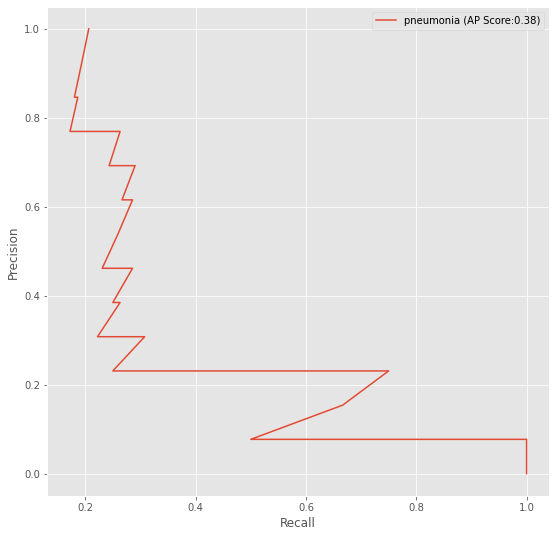

In [46]:
plot_pr(valY, pred_Y)

In [47]:
def plot_f1_thres_curve(valY, pred_Y):
    fig, c_ax = plt.subplots(1, 1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_scores = 2*(precision*recall/(precision+recall))
    c_ax.plot(thresholds, f1_scores, label='F1-Scores - Thresholds Curve')
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1-Scores')

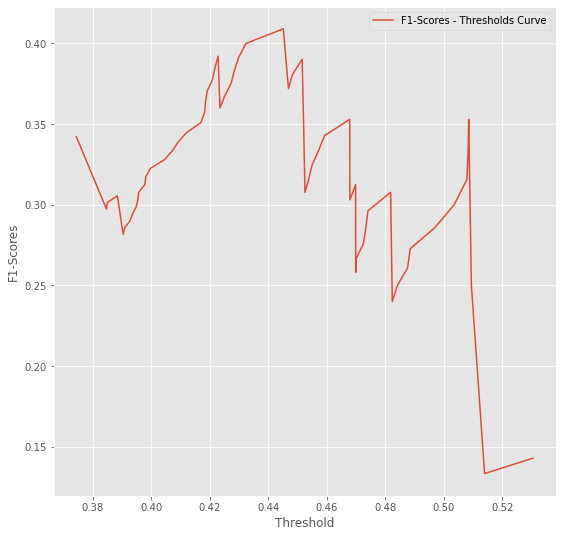

In [48]:
plot_f1_thres_curve(valY, pred_Y)

Saving New Model to .json 

In [49]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# New Model 2

In [50]:
new_model2 = Sequential()
new_model2.add(vgg_model)
new_model2.add(Flatten())
new_model2.add(Dropout(0.4))
new_model2.add(Dense(1024, activation='relu'))
new_model2.add(Dropout(0.4))
new_model2.add(Dense(512, activation='relu'))
new_model2.add(Dropout(0.4))
new_model2.add(Dense(256, activation='relu'))
new_model2.add(Dense(1, activation='sigmoid'))

In [51]:
new_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [52]:
weight_path2="{}_my_model2.best.hdf5".format('xray_class')


checkpoint2 = ModelCheckpoint(weight_path2, monitor= 'val_binary_accuracy', verbose=1, save_best_only=True, mode= 'max', save_weights_only = True)
early2 = EarlyStopping(monitor= 'val_loss', mode= 'min', patience=10)

callbacks_list2 = [checkpoint2, early2]

In [53]:
weight_path2

'xray_class_my_model2.best.hdf5'

In [54]:
## Just run a single epoch to see how it does:
history2 = new_model2.fit_generator(train_gen, validation_data = (valX, valY), epochs = 10, callbacks=callbacks_list2 )

Epoch 1/10
36/36 [==============================] - 61s 2s/step - loss: 0.7320 - binary_accuracy: 0.5153 - val_loss: 0.6655 - val_binary_accuracy: 0.6406

Epoch 00001: val_binary_accuracy improved from -inf to 0.64062, saving model to xray_class_my_model2.best.hdf5
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.6932 - binary_accuracy: 0.5511 - val_loss: 0.6054 - val_binary_accuracy: 0.6719

Epoch 00002: val_binary_accuracy improved from 0.64062 to 0.67188, saving model to xray_class_my_model2.best.hdf5
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6692 - binary_accuracy: 0.5869 - val_loss: 0.7416 - val_binary_accuracy: 0.5312

Epoch 00003: val_binary_accuracy did not improve from 0.67188
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6615 - binary_accuracy: 0.6009 - val_loss: 0.6229 - val_binary_accuracy: 0.6562

Epoch 00004: val_binary_accuracy did not improve from 0.67188
Epoch 5/10
36/36 [=============

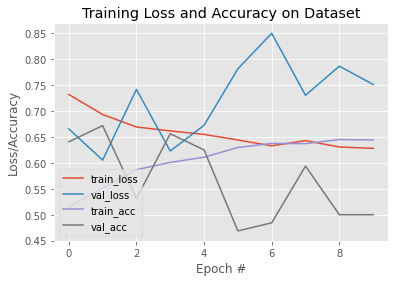

In [55]:
plot_history(history2)

In [56]:
new_model2.load_weights(weight_path2)
pred_Y2 = new_model2.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 11ms/step


In [57]:
key_metrics(valY, pred_Y2)

TRAIN METRIC ----------------------
Train acc: 60.39%
TEST METRICS ----------------------
Accuracy: 67.1875%
True Negative: 35
True Positive: 8
False Negative: 5
False Positive: 16
 
Sensitivity: 0.6153846153846154
 
specificity: 0.6862745098039216
 
Confusion Matrix: [[35 16]
 [ 5  8]]
 
Threshold where Precision is 0.8--------------------
Precision is: 1.0
Recall is: 0.07692307692307693
Threshold is: 0.62786263
F1 Score is: 0.14285714285714288
 
Threshold where Recall is 0.8--------------------
Precision is: 0.23809523809523808
Recall is: 0.7692307692307693
Threshold is: 0.3527323
F1 Score is: 0.36363636363636365


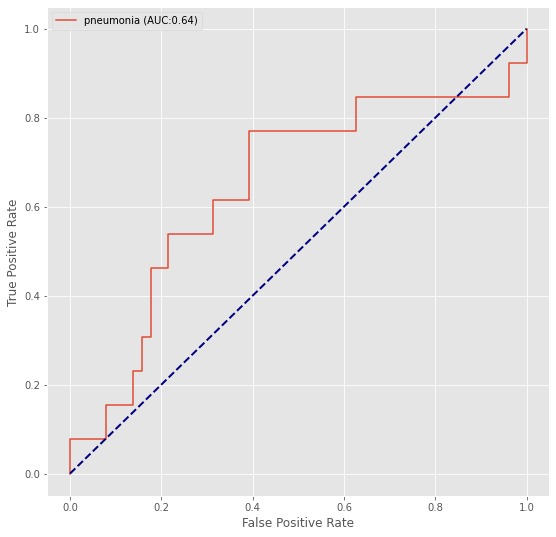

In [58]:
plot_auc(valY, pred_Y2)

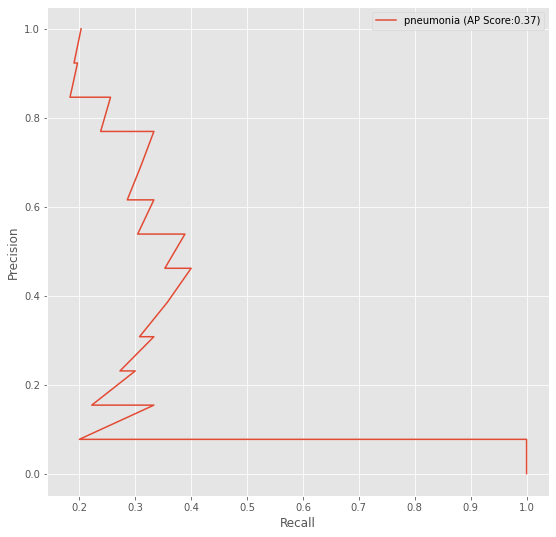

In [59]:
plot_pr(valY, pred_Y2)

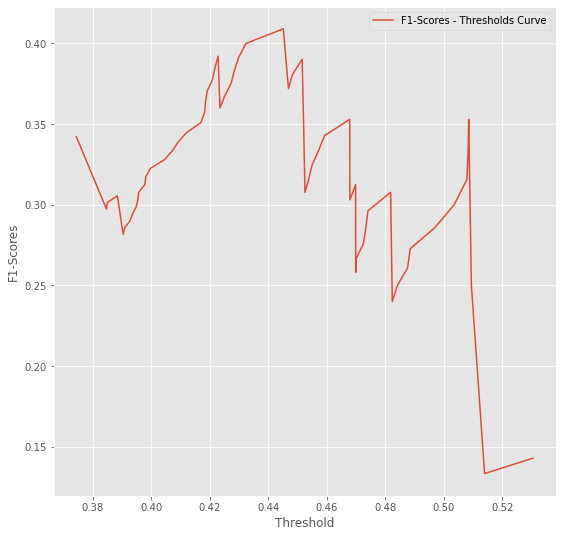

In [60]:
plot_f1_thres_curve(valY, pred_Y)

In [61]:
model_json2 = new_model2.to_json()
with open("my_model2.json", "w") as json_file:
    json_file.write(model_json2)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

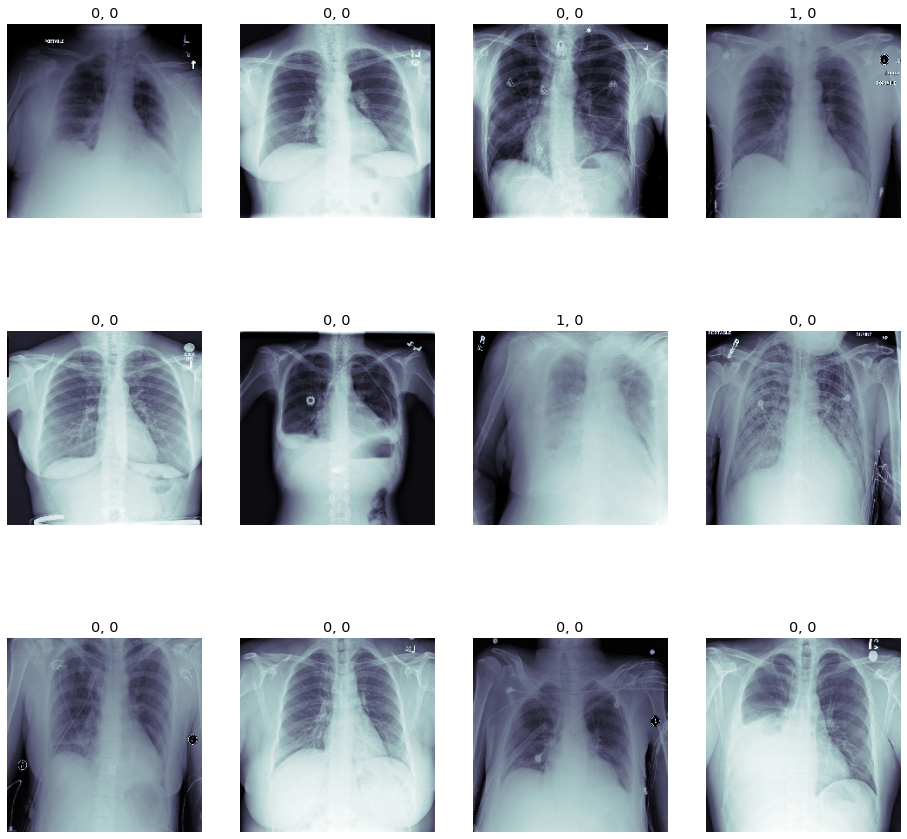

In [63]:
Best_Thresholds= 0.62786263  ## Best Threshold of Model 2 at 80% Precision 
fig, m_axs = plt.subplots(3,4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Best_Thresholds:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Best_Thresholds: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1